# Imports

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from scipy.spatial import distance
from sklearn.metrics.pairwise import manhattan_distances

# Loading Datasets

In [2]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Load Preporcessed Dataset

In [3]:
# loading images
images_real = load_obj_real("cifar_32_32")
images_trans = load_obj_real("trans_cifar_32_32")
images_sn = load_obj_real("SNGAN_Steffen_cifar_32_32")
images_dc = load_obj_real("DCGAN_Steffen_cifar_32_32")
images_fid = load_obj_real("SNGAN_FID_Steffen_cifar_32_32")

Real Images: 49996
Trans Images: 10000
SN Images: 49950
DC Images: 49950
FID Images: 49950


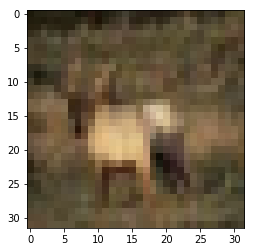

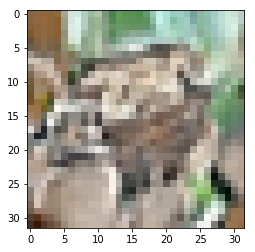

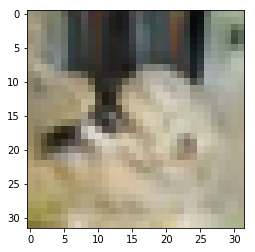

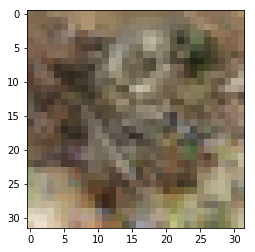

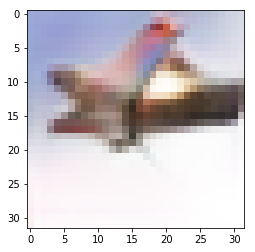

In [4]:
# Example image
print("Real Images:", len(images_real))
print("Trans Images:", len(images_trans))
print("SN Images:", len(images_sn))
print("DC Images:", len(images_dc))
print("FID Images:", len(images_fid))
imgplot = plt.imshow(images_real[3])
plt.show()
imgplot = plt.imshow(images_trans[3])
plt.show()
imgplot = plt.imshow(images_sn[3])
plt.show()
imgplot = plt.imshow(images_dc[3])
plt.show()
imgplot = plt.imshow(images_fid[3])
plt.show()

## Real Images

# Analyzing Images

## Creating FFT

In [5]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

# Create Informations
def create_informations(images, normalized= False):
    two_dim = fft(images[0])
    if normalized:
        two_dim = two_dim /two_dim.max()
    m,n = two_dim.shape
    zero_axis = np.sum(two_dim, axis=0)/m
    one_axis = np.sum(two_dim, axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals /fft_vals.max()
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(two_dim, axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(two_dim, axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals/fft_vals.max()
        std_zero_axis = std_zero_axis + ((np.sum(fft_vals, axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft_vals, axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

Text(0.5, 0.98, 'Comparison between Real, TransGAN, SNGAN, DCGAN, SNGAN_FID - left: colomn wise right: row-wise')

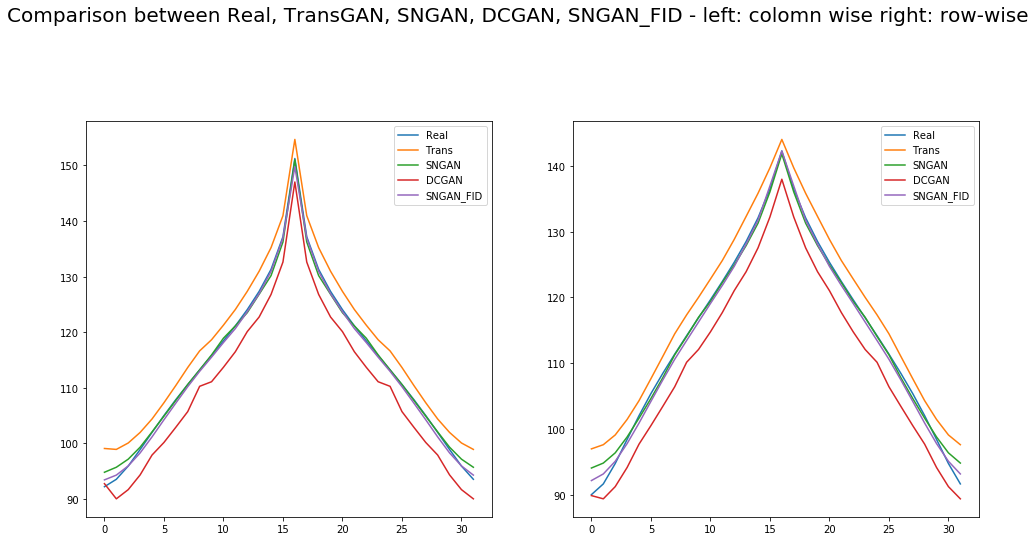

In [6]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
two_dim_t, zero_axis_t, one_axis_t, m_t, n_t,min_zero_axis_t,max_zero_axis_t, min_one_axis_t, max_one_axis_t, std_zero_axis_t, std_one_axis_t = create_informations(images_trans)
two_dim_s, zero_axis_s, one_axis_s, m_s, n_s,min_zero_axis_s,max_zero_axis_s, min_one_axis_s, max_one_axis_s, std_zero_axis_s, std_one_axis_s = create_informations(images_sn)
two_dim_d, zero_axis_d, one_axis_d, m_d, n_d,min_zero_axis_d,max_zero_axis_d, min_one_axis_d, max_one_axis_d, std_zero_axis_d, std_one_axis_d = create_informations(images_dc)
two_dim_f, zero_axis_f, one_axis_f, m_f, n_f,min_zero_axis_f,max_zero_axis_f, min_one_axis_f, max_one_axis_f, std_zero_axis_f, std_one_axis_f = create_informations(images_fid)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real')
ax1.plot(range(len(zero_axis_t)),zero_axis_t, label='Trans')
ax1.plot(range(len(zero_axis_s)),zero_axis_s, label='SNGAN')
ax1.plot(range(len(zero_axis_d)),zero_axis_d, label='DCGAN')
ax1.plot(range(len(zero_axis_f)),zero_axis_f, label='SNGAN_FID')

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real')
ax2.plot(range(len(one_axis_t)),one_axis_t, label='Trans')
ax2.plot(range(len(one_axis_s)),one_axis_s, label='SNGAN')
ax2.plot(range(len(one_axis_d)),one_axis_d, label='DCGAN')
ax2.plot(range(len(one_axis_f)),one_axis_f, label='SNGAN_FID')

leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, TransGAN, SNGAN, DCGAN, SNGAN_FID - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real, TransGAN, SNGAN, DCGAN, SNGAN_FID - left: colomn wise right: row-wise')

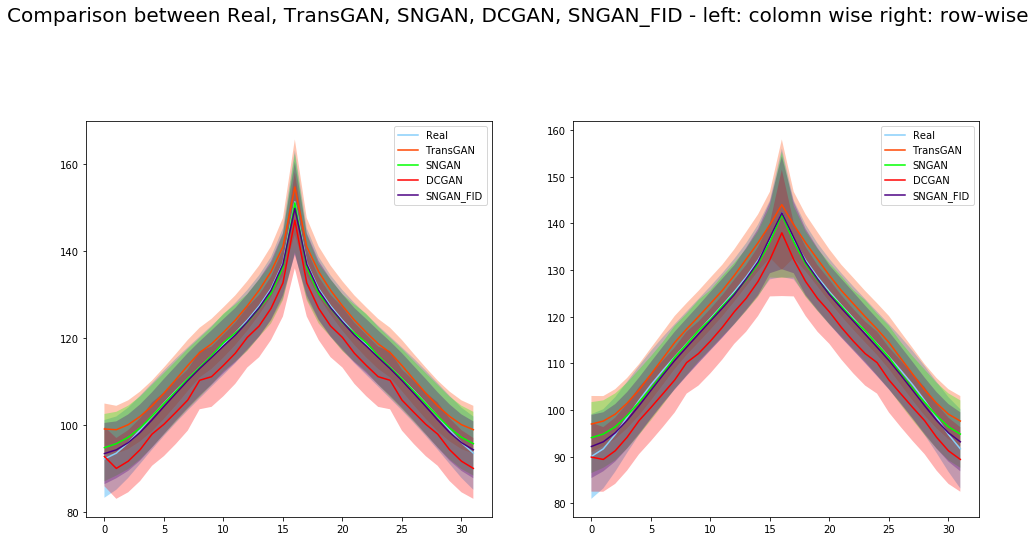

In [7]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r + std_zero_axis_r, zero_axis_r -std_zero_axis_r,facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_t)),zero_axis_t, label='TransGAN', color ='orangered')
ax1.fill_between(range(m_t), zero_axis_t + std_zero_axis_t, zero_axis_t -std_zero_axis_t,facecolor='orangered', alpha=0.3)
ax1.plot(range(len(zero_axis_s)),zero_axis_s, label='SNGAN', color ='lime')
ax1.fill_between(range(m_s), zero_axis_s + std_zero_axis_s, zero_axis_s -std_zero_axis_s,facecolor='lime', alpha=0.3)
ax1.plot(range(len(zero_axis_d)),zero_axis_d, label='DCGAN', color ='red')
ax1.fill_between(range(m_d), zero_axis_d + std_zero_axis_d, zero_axis_d -std_zero_axis_d,facecolor='red', alpha=0.3)
ax1.plot(range(len(zero_axis_f)),zero_axis_f, label='SNGAN_FID', color ='indigo')
ax1.fill_between(range(m_f), zero_axis_f+ std_zero_axis_f, zero_axis_f -std_zero_axis_f,facecolor='indigo', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r + std_one_axis_r, one_axis_r -std_one_axis_r,facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_t)),one_axis_t, label='TransGAN',color = 'orangered')
ax2.fill_between(range(m_t), one_axis_t + std_one_axis_t, one_axis_t -std_one_axis_t,facecolor='orangered', alpha=0.3)
ax2.plot(range(len(one_axis_s)),one_axis_s, label='SNGAN',color = 'lime')
ax2.fill_between(range(m_s), one_axis_s + std_one_axis_s, one_axis_s -std_one_axis_s,facecolor='lime', alpha=0.3)
ax2.plot(range(len(one_axis_d)),one_axis_d, label='DCGAN',color = 'red')
ax2.fill_between(range(m_d), one_axis_d + std_one_axis_d, one_axis_d -std_one_axis_d,facecolor='red', alpha=0.3)
ax2.plot(range(len(one_axis_f)),one_axis_f, label='SNGAN_FID',color = 'indigo')
ax2.fill_between(range(m_f), one_axis_f + std_one_axis_f, one_axis_f -std_one_axis_f,facecolor='indigo', alpha=0.3)


leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, TransGAN, SNGAN, DCGAN, SNGAN_FID - left: colomn wise right: row-wise", fontsize=20)

In [10]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [9]:
print("KL-Divergence (column):")
print("Trans:", kl_divergence(zero_axis_r,zero_axis_t))
print("SNGAN:", kl_divergence(zero_axis_r,zero_axis_s))
print("DCGAN:", kl_divergence(zero_axis_r,zero_axis_d))
print("SNGAN_FID:", kl_divergence(zero_axis_r,zero_axis_f))
print()
print("KL-Divergence (row):")
print("Trans:", kl_divergence(one_axis_r,one_axis_t))
print("SNGAN:", kl_divergence(one_axis_r,one_axis_s))
print("DCGAN:", kl_divergence(one_axis_r,one_axis_d))
print("SNGAN_FID:", kl_divergence(one_axis_r,one_axis_f))
print()
print("KL-Divergence (col vs row):")
print("Real:", kl_divergence(zero_axis_r,one_axis_r))
print("Trans:", kl_divergence(zero_axis_t,one_axis_t))
print("SNGAN:", kl_divergence(zero_axis_s,one_axis_s))
print("DCGAN:", kl_divergence(zero_axis_d,one_axis_d))
print("SNGAN_FID:", kl_divergence(zero_axis_f,one_axis_f))

KL-Divergence (column):
Trans: -107.6728584159312
SNGAN: -4.575189751284001
DCGAN: 137.77669904935698
SNGAN_FID: 10.602941177448107

KL-Divergence (row):
Trans: -107.60311041072691
SNGAN: -4.454519541427898
DCGAN: 137.73958916979316
SNGAN_FID: 10.669522914942652

KL-Divergence (col vs row):
Real: 0.44492513349616836
Trans: 0.5499598724643464
SNGAN: 0.38058666588425893
DCGAN: 0.4077628113131082
SNGAN_FID: 0.279489946426982


In [11]:
print("Manhattan distance (column):")
print("Trans:", manhattan_distances([zero_axis_r],[zero_axis_t])[0][0])
print("SNGAN:", manhattan_distances([zero_axis_r],[zero_axis_s])[0][0])
print("DCGAN:", manhattan_distances([zero_axis_r],[zero_axis_d])[0][0])
print("SNGAN_FID:", manhattan_distances([zero_axis_r],[zero_axis_f])[0][0])
print()
print("Manhattan distance (row):")
print("Trans:", manhattan_distances([one_axis_r],[one_axis_t])[0][0])
print("SNGAN:", manhattan_distances([one_axis_r],[one_axis_s])[0][0])
print("DCGAN:", manhattan_distances([one_axis_r],[one_axis_d])[0][0])
print("SNGAN_FID:", manhattan_distances([one_axis_r],[one_axis_f])[0][0])
print()
print("Manhattan distance (col vs row):")
print("Real:", manhattan_distances([zero_axis_r],[one_axis_r])[0][0])
print("Trans:", manhattan_distances([zero_axis_t],[one_axis_t])[0][0])
print("SNGAN:", manhattan_distances([zero_axis_s],[one_axis_s])[0][0])
print("DCGAN:", manhattan_distances([zero_axis_d],[one_axis_d])[0][0])
print("SNGAN_FID:", manhattan_distances([zero_axis_f],[one_axis_f])[0][0])

Manhattan distance (column):
Trans: 109.48088108041823
SNGAN: 18.637469429861795
DCGAN: 136.1519713361045
SNGAN_FID: 16.116966577436017

Manhattan distance (row):
Trans: 109.48088108043288
SNGAN: 24.33402298375249
DCGAN: 135.05287197926697
SNGAN_FID: 24.16498763929056

Manhattan distance (col vs row):
Real: 38.956706323938135
Trans: 41.7490913441941
SNGAN: 31.65375059179472
DCGAN: 31.33215537251641
SNGAN_FID: 28.339502183174346


In [12]:
dist = np.linalg.norm(zero_axis_s-one_axis_s)
print("Euclidean distance (column):")
print("Trans:", np.linalg.norm(zero_axis_r-zero_axis_t))
print("SNGAN:", np.linalg.norm(zero_axis_r-zero_axis_s))
print("DCGAN:", np.linalg.norm(zero_axis_r-zero_axis_d))
print("SNGAN_FID:", np.linalg.norm(zero_axis_r-zero_axis_f))
print()
print("Euclidean distance (row):")
print("Trans:", np.linalg.norm(one_axis_r-one_axis_t))
print("SNGAN:", np.linalg.norm(one_axis_r-one_axis_s))
print("DCGAN:", np.linalg.norm(one_axis_r-one_axis_d))
print("SNGAN_FID:", np.linalg.norm(one_axis_r-one_axis_f))
print()
print("Euclidean distance (col vs row):")
print("Real:", np.linalg.norm(zero_axis_r-one_axis_r))
print("Trans:", np.linalg.norm(zero_axis_r-one_axis_r))
print("SNGAN:", np.linalg.norm(zero_axis_r-one_axis_r))
print("DCGAN:", np.linalg.norm(zero_axis_r-one_axis_r))
print("SNGAN_FID:", np.linalg.norm(zero_axis_r-one_axis_r))

Euclidean distance (column):
Trans: 20.110179218008774
SNGAN: 5.057845498766798
DCGAN: 24.539609510452394
SNGAN_FID: 3.328842795602654

Euclidean distance (row):
Trans: 20.315857423841656
SNGAN: 6.884109664606287
DCGAN: 24.51650501787078
SNGAN_FID: 4.882907259995806

Euclidean distance (col vs row):
Real: 10.796220688325816
Trans: 10.796220688325816
SNGAN: 10.796220688325816
DCGAN: 10.796220688325816
SNGAN_FID: 10.796220688325816


## Normalized

Text(0.5, 0.98, 'Comparison between Real, TransGAN, SNGAN, DCGAN, SNGAN_FID (Normalized) - left: colomn wise right: row-wise')

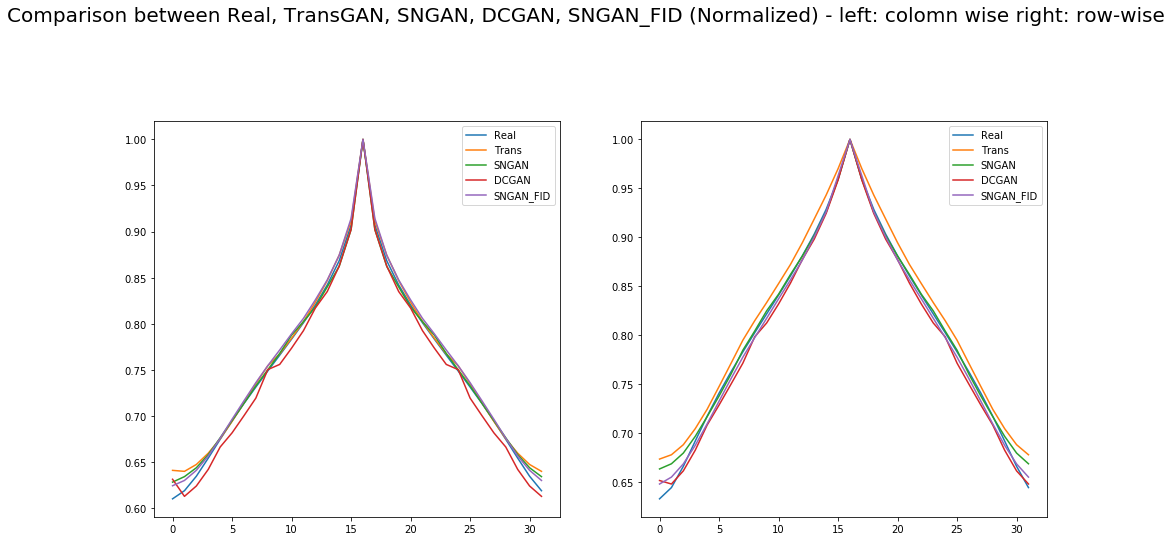

In [7]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real')
ax1.plot(range(len(zero_axis_t)),zero_axis_t/zero_axis_t.max(), label='Trans')
ax1.plot(range(len(zero_axis_s)),zero_axis_s/zero_axis_s.max(), label='SNGAN')
ax1.plot(range(len(zero_axis_d)),zero_axis_d/zero_axis_d.max(), label='DCGAN')
ax1.plot(range(len(zero_axis_f)),zero_axis_f/zero_axis_f.max(), label='SNGAN_FID')

ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real')
ax2.plot(range(len(one_axis_t)),one_axis_t/one_axis_t.max(), label='Trans')
ax2.plot(range(len(one_axis_s)),one_axis_s/one_axis_s.max(), label='SNGAN')
ax2.plot(range(len(one_axis_d)),one_axis_d/one_axis_d.max(), label='DCGAN')
ax2.plot(range(len(one_axis_f)),one_axis_f/one_axis_f.max(), label='SNGAN_FID')

leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, TransGAN, SNGAN, DCGAN, SNGAN_FID (Normalized) - left: colomn wise right: row-wise", fontsize=20)

In [18]:
print("KL-Divergence (column):")
print("Trans:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_t/zero_axis_t.max()))
print("SNGAN:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_s/zero_axis_s.max()))
print("DCGAN:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_d/zero_axis_d.max()))
print("SNGAN_FID:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_f/zero_axis_f.max()))
print()
print("KL-Divergence (row):")
print("Trans:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_t/one_axis_t.max()))
print("SNGAN:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_s/one_axis_s.max()))
print("DCGAN:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_d/one_axis_d.max()))
print("SNGAN_FID:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_f/one_axis_f.max()))

KL-Divergence (column):
Trans: -0.17075431997645224
SNGAN: -0.06717548557035086
DCGAN: 0.22777584398882703
SNGAN_FID: -0.16666814347302708

KL-Divergence (row):
Trans: -0.4433399946086024
SNGAN: -0.111230562268821
DCGAN: 0.18132726264285676
SNGAN_FID: 0.07201454547786218


In [19]:
print("Manhattan distance (column):")
print("Trans:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_t/zero_axis_t.max()])[0][0])
print("SNGAN:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_s/zero_axis_s.max()])[0][0])
print("DCGAN:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_d/zero_axis_d.max()])[0][0])
print("SNGAN_FID:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_f/zero_axis_f.max()])[0][0])
print()
print("Manhattan distance (row):")
print("Trans:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_t/one_axis_t.max()])[0][0])
print("SNGAN:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_s/one_axis_s.max()])[0][0])
print("DCGAN:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_d/one_axis_d.max()])[0][0])
print("SNGAN_FID:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_f/one_axis_f.max()])[0][0])

Manhattan distance (column):
Trans: 0.17464671619917915
SNGAN: 0.1296479429146732
DCGAN: 0.2742481816141712
SNGAN_FID: 0.1674769914778801

Manhattan distance (row):
Trans: 0.44910493521736805
SNGAN: 0.1538152529532807
DCGAN: 0.23182146317229568
SNGAN_FID: 0.1681049618273439


In [20]:
dist = np.linalg.norm(zero_axis_s-one_axis_s)
print("Euclidean distance (column):")
print("Trans:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_t/zero_axis_t.max()))
print("SNGAN:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_s/zero_axis_s.max()))
print("DCGAN:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_d/zero_axis_d.max()))
print("SNGAN_FID:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_f/zero_axis_f.max()))
print()
print("Euclidean distance (row):")
print("Trans:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_t/one_axis_t.max()))
print("SNGAN:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_s/one_axis_s.max()))
print("DCGAN:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_d/one_axis_d.max()))
print("SNGAN_FID:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_f/one_axis_f.max()))

Euclidean distance (column):
Trans: 0.04995985283975365
SNGAN: 0.03457320053315727
DCGAN: 0.05430844516396409
SNGAN_FID: 0.033938909144670126

Euclidean distance (row):
Trans: 0.09183226797430347
SNGAN: 0.05108227953882469
DCGAN: 0.04720922412591814
SNGAN_FID: 0.03411504947205377
